In [1]:
%%time
# Python 2.7

%matplotlib nbagg
%matplotlib inline 

import sys
sys.path.append('..')
print(sys.version)

import os
import cPickle 
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import lasagne 
import lasagne.layers as L
import parmesan
import cPickle as pickle

from sklearn.utils import shuffle

import tools as tls
from data_loaders import svhn



/home/icarus/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


2.7.12 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 35.0% of memory, cuDNN 5105)


CPU times: user 1.91 s, sys: 1.25 s, total: 3.15 s
Wall time: 6.48 s


In [2]:
### GLOBAL PARAMETERS ###
plot_train   = True
using_shared = False

### META - HOW THE PROGRAM WORKS

np.random.seed(1234) # reproducibility


### CONSTANTS
dataset = 'MNIST'
dataset = 'SVHN'
print('dataset = {}'.format(dataset))

if dataset == 'SVHN':    
    file_name = 'data_svhn_c3' # assumes '.pkl'
    IMG_LEN = 32
    IMG_DEPTH = 3
    cmap = None
elif dataset == 'MNIST':
    IMG_LEN = 28
    IMG_DEPTH = 1
    cmap = 'gray'
    


dataset = SVHN


In [3]:
### PLOT SETTINGS

plt.rcParams["figure.figsize"] = (8,5)
font_size = 15
plt.rc('font',   size=font_size)       # controls default text sizes
plt.rc('axes',   titlesize=font_size)  # fontsize of the axes title
plt.rc('axes',   labelsize=font_size)  # fontsize of the x any y labels
plt.rc('xtick',  labelsize=font_size)  # fontsize of the tick labels
plt.rc('ytick',  labelsize=font_size)  # fontsize of the tick labels
plt.rc('legend', fontsize=font_size)   # legend fontsize
plt.rc('figure', titlesize=font_size)  # # size of the figure title


In [4]:
# %%time
### LOAD DATA

if dataset == 'SVHN':
    full_path = os.path.join(os.getcwd(), 'data')
    full_path = os.path.join(full_path, file_name)
    full_path  += '.pkl'
    print(full_path)

    with open(full_path, 'rb') as f:
        x_trai, t_trai, x_vali, t_vali, x_test, t_test = pickle.load(f)

    x_trai = x_trai/255
    x_vali = x_vali/255
    x_test = x_test/255


elif dataset == 'MNIST':
    full_path = os.path.join(os.getcwd(), 'data')
    full_path = os.path.join(full_path  , 'mnist.npz')

    data = np.load(full_path)
    x_trai = data['X_train'].astype('float32')
    t_trai = data['y_train'].astype('int32')

    x_vali = data['X_valid'].astype('float32')
    t_vali = data['y_valid'].astype('int32')

    x_test = data['X_test'].astype('float32')
    t_test = data['y_test'].astype('int32')


    t_trai = tls.onehot(t_trai, 10)
    t_vali = tls.onehot(t_vali, 10)
    t_test = tls.onehot(t_test, 10)



### CHECK DATA
num_classes = t_trai.shape[1]
print('Number of classes {}'.format(num_classes))

num_features = x_trai[0].shape[0]
print('Number of features {}'.format(num_features))

print('')
print('Train shape: ', 
      x_trai.shape, t_trai.shape)

print('Valid shape: ', 
      x_vali.shape, t_vali.shape)

print('Test shape:  ', 
      x_test.shape, t_test.shape)

print('{}'.format(type(x_trai)))
print('{}'.format(type(x_vali)))
print('{}'.format(type(x_test)))
print('')

print('Prior (percent)')
print(np.round(np.sum(t_trai, axis=0)/t_trai.shape[0]*1000)/10.)
print(np.round(np.sum(t_test, axis=0)/t_test.shape[0]*1000)/10.)


print('Size of total dataset: {:.2f} MB'.format(
        (
              sys.getsizeof(x_trai)
            + sys.getsizeof(t_trai)
            + sys.getsizeof(x_vali)
            + sys.getsizeof(t_vali)
            + sys.getsizeof(x_test)
            + sys.getsizeof(t_test)
        )/1.0e6))


/home/icarus/02456-VAE/svhn/data/data_svhn_c3.pkl
Number of classes 3
Number of features 3072

('Train shape: ', (25362, 3072), (25362, 3))
('Valid shape: ', (4032, 3072), (4032, 3))
('Test shape:  ', (10992, 3072), (10992, 3))
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>

Prior (percent)
[ 16.8  47.1  36.1]
[ 15.9  46.4  37.7]
Size of total dataset: 497.23 MB


In [5]:
# ### LAZY REDUCTION OF DATA SET SIZE
# x_trai = x_trai[:10000]
# t_trai = t_trai[:10000]

# x_trai = x_trai[:10000]
# t_trai = t_trai[:10000]

# x_trai = x_trai[:10000]
# t_trai = t_trai[:10000]



In [6]:
# Generate a subset of labeled data points

num_labeled = 100 # per class

idxs_train_l = []
for i in range(num_classes):
    idxs = np.where(np.argmax(t_trai,axis=-1) == i)[0]
    idxs_train_l += np.random.choice(idxs, size=num_labeled).tolist()

x_train_l = x_trai[idxs_train_l].astype('float32')
t_train_l = (t_trai[idxs_train_l,:]).astype('float32')

In [7]:
### More data checks
# Ensure that we have one hot encoding, and that the 
print('Label check')
print(t_vali[:10,:])
print(np.where(t_trai == 1)[1][:10])

print("If you don't get a 10xNUM_CLASS matrix, and a list with the",
      "index of the 1 of each row, something went wrong.")

print
print('Input check')
### Ensure that the data is scalled appropriately (between 0 and 1)

print('\nMaximum training value: {}'.format(np.max(x_trai)))
if np.max(x_trai) > 1:
    print('WARNING!! Maximum value in input data is {}'.format(np.max(x_trai)))
else:
    print('Input: fine')

Label check
[[ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
[1 2 1 0 1 1 2 1 1 2]
("If you don't get a 10xNUM_CLASS matrix, and a list with the", 'index of the 1 of each row, something went wrong.')

Input check

Maximum training value: 1.0
Input: fine


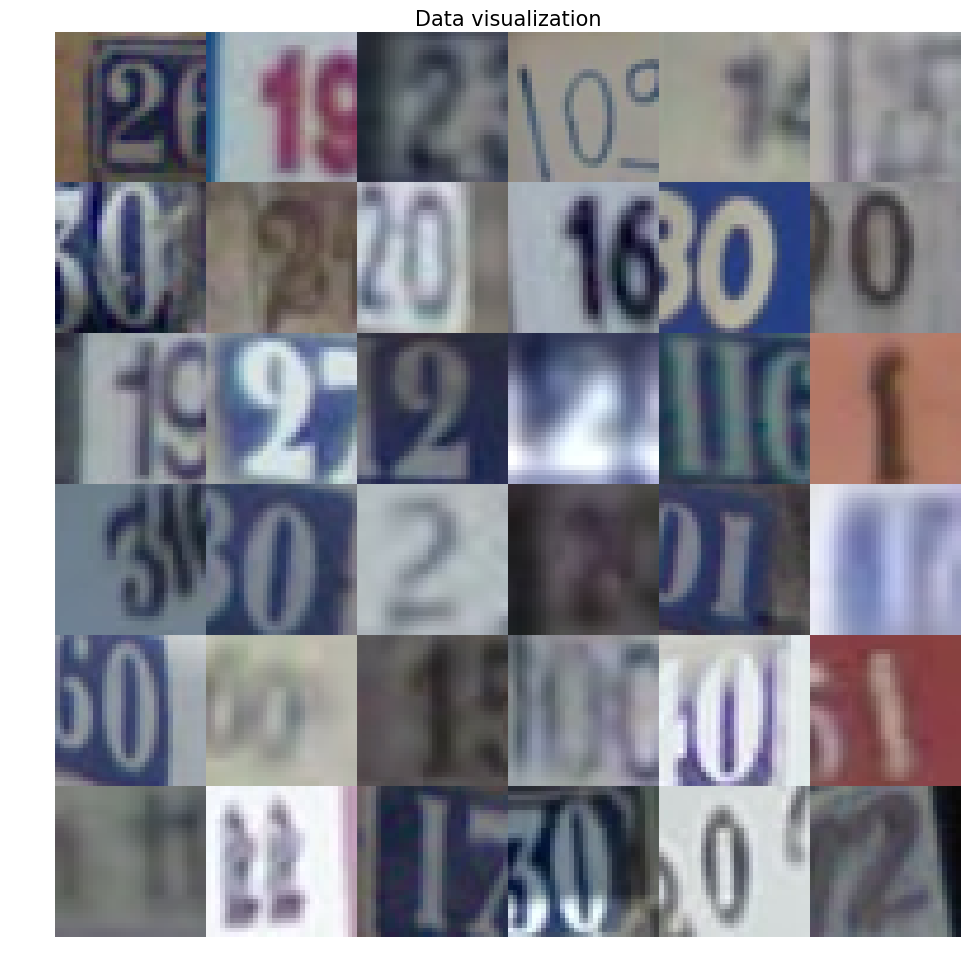

[[ 2.  1.  2.  0.  1.  2.]
 [ 0.  2.  0.  1.  0.  0.]
 [ 1.  2.  2.  2.  1.  1.]
 [ 0.  0.  2.  2.  1.  1.]
 [ 0.  0.  1.  0.  0.  1.]
 [ 1.  2.  1.  0.  0.  2.]]


In [8]:
### VISUALIZE 
canv, lab = tls.plot_svhn(x_trai, t_trai, t=6, IMG_LEN=IMG_LEN, 
                          IMG_DEPTH=IMG_DEPTH, cmap=cmap)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(canv, cmap=cmap, interpolation='nearest')

ax.set_title('Data visualization')
ax.axis('off')
plt.tight_layout()
plt.show()

print(lab) # The labels associated with the plot

In [9]:
### HYPER PARAMETERS
# VOLATILE HP
learning_rate = 1e-3
smooth_factor=0.01
L1 = 0
L2 = 0

samples_to_process = 1e7
val_interval=1e4
batch_size = 100




# ARCHITECTURE
fraction = 0.1
hid_size = 128
num_latent_1 = round(hid_size*fraction)
skip_connections=True
deconv_rec=False
bernuli_sampling_train=False

conv_net_class=True

# STABLE HP
eq_size = 1
iw_size = 1


#Prior y
prior_y=np.mean(t_trai,axis=0).reshape(1,-1).astype('float32')

In [10]:
### HELPER FUNCTIONS
from lasagne.objectives import squared_error

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes)).astype('float32')
    for row, col in enumerate(t):
        out[row, col] = 1
    return out


# c = -0.5 * np.log(2*np.pi)
clip = lambda x: T.clip(x,-10,10) #used to limit the variance (why?)

def log_bernoulli(x, p, eps=1e-32):
    """
    Computes the binary cross-entropy between a target and 

    Use eps if you don't want to alow values ==0, ==1
    """

    p = T.clip(p, eps, 1.0 - eps)
    return -T.nnet.binary_crossentropy(p, x)



def kl_normal_2_stdnormal(mu, lv):
    """Compute the KL divergence from the standard normal dist"""
    return - 0.5 * (1 + lv - mu**2 - T.exp(lv))


def ReconLogLikelihood(mux, x, muq, lvq,KL_weigth=1):
    """
    Compute the cost of the network, using 
    """
    #Sum over the latent dimension, mean over the the samples
    #reconstruction_cost = -squared_error(x, mux).sum(axis=1).mean()
    reconstruction_cost = log_bernoulli(x, mux).sum(axis=1)
    #epsilon = 1e-8
    #reconstruction_cost =( x * T.log(mux + epsilon) + (1-x)*T.log(1-mux+epsilon))
    KL_qp = kl_normal_2_stdnormal(muq, lvq).sum(axis=1)#.mean()
    
    LL = reconstruction_cost - KL_qp * KL_weigth
    
    return LL, reconstruction_cost, KL_qp


def LogSumExp(x, axis=None, keepdims=False):
    ''' Numerically stable theano version of the Log-Sum-Exp trick'''
    x_max = T.max(x, axis=axis, keepdims=True)

    preres = T.log(T.sum(T.exp(x - x_max), axis=axis, keepdims=keepdims))
    return preres + x_max.reshape(preres.shape)

def img_transform(x,reverse=False):
    if reverse:
        x=x.swapaxes(1,2)
        x=x.swapaxes(2,3)
        x=x.reshape((x.shape[0],IMG_LEN*IMG_LEN*IMG_DEPTH))
    else:
        x=x.reshape((x.shape[0],IMG_LEN, IMG_LEN, IMG_DEPTH))
        x=x.swapaxes(2,3)
        x=x.swapaxes(1,2)
    return x

In [11]:
# %%time
### CREATE MODEL
from lasagne.nonlinearities import leaky_rectify, rectify, sigmoid,softmax
from parmesan.layers import SampleLayer
### CLASSIFIER
l_in_x   = L.InputLayer(shape=(None, num_features))#, name='l_in_x')
l_in_y   = L.InputLayer(shape=(None, num_classes))#, name='l_in_y')
l_in_x_con= L.InputLayer(shape=(None, num_features))#, name='l_in_x')


l_cl_1   = L.DenseLayer(l_in_x, 
                        num_units=hid_size,
                        nonlinearity=rectify)#,
#                        name='l_cl_1')
l_cl_2   = L.DenseLayer(l_cl_1,
                        num_units=hid_size,
                        nonlinearity=rectify)#,
#                        name='l_cl_2')
if skip_connections:
    l_cl_2=L.ConcatLayer([l_cl_1,l_cl_2])

l_y    = L.DenseLayer(l_cl_2, 
                        num_units=num_classes,
                        nonlinearity=softmax)#,
#                        name='l_y')
    
    
### ENCODER
l_en_con = L.ConcatLayer([l_in_x, l_in_y])#,name='l_en_con')

l_en_1   = L.DenseLayer(l_en_con, 
                        num_units=hid_size,
                        nonlinearity=rectify)#,
#                        name='l_en_1')

l_en_2   = L.DenseLayer(l_en_1,
                        num_units=hid_size,
                        nonlinearity=rectify)#,
#                        name='l_en_2')
if skip_connections:
    l_en_2=L.ConcatLayer([l_en_1,l_en_2])

# Create latent parameters
l_mu_1   = L.DenseLayer(l_en_2,
                        num_units=num_latent_1,
                        nonlinearity=None)#,
#                        name='l_mu_1')
l_lv_1   = L.DenseLayer(l_en_2,
                        num_units=num_latent_1,
                        nonlinearity=clip)#,
#                        name='l_lv_1')

# sample a latent representation:
#    z ~ q(z|x) = N(mu(x), logvar(x)
l_z_1      = SampleLayer(mean=l_mu_1, 
                         log_var=l_lv_1, 
                         eq_samples=eq_size, 
                         iw_samples=iw_size)#, 
#                         name='l_z_1')

### DECODER

l_in_z   = L.InputLayer(shape=(None, num_latent_1))#,
#                        name = 'l_in_z')

l_dec_con = L.ConcatLayer([l_in_z, l_in_y])#,name='l_en_con')

l_dec_1  = L.DenseLayer(l_dec_con, 
                        num_units = hid_size,
                        nonlinearity = rectify)#,
#                        name = 'l_dec_1')
l_dec_2  = L.DenseLayer(l_dec_1, 
                        num_units = hid_size,
                        nonlinearity = rectify)#,
#                       name='l_dec_2')
if skip_connections:
    l_dec_2=L.ConcatLayer([l_dec_con,l_dec_1,l_dec_2])
# Sigmoid is used because the original images are $\in [0,1]$
l_out    = L.DenseLayer(l_dec_2, 
                        num_units=num_features,
                        nonlinearity=sigmoid)#,
#                        name='l_out')


## CONVULUTIONAL CLASSIFIER
l_in_class       = L.InputLayer(shape=(None,IMG_DEPTH,IMG_LEN,IMG_LEN)) #note that we use a 4D input since we need to retain the spatial arrangement of the pixels when working with convolutions
l_conv_cl_1      = L.Conv2DLayer(l_in_class      , num_filters=hid_size//32, filter_size=3, pad=(1,1))#32*32*hid_size//32
l_conv_cl_1_pool = L.MaxPool2DLayer(l_conv_cl_1  , pool_size=(2, 2)        , stride = 2)
l_conv_cl_2      = L.Conv2DLayer(l_conv_cl_1_pool, num_filters=hid_size//16, filter_size=3, pad=(1,1))#16*16*hid_size//16
l_conv_cl_2_pool = L.MaxPool2DLayer(l_conv_cl_2  , pool_size=(2, 2)        , stride = 2)
l_conv_cl_3      = L.Conv2DLayer(l_conv_cl_2_pool, num_filters=hid_size//8 , filter_size=3)#6*6*hid_size//8
l_conv_cl_3_pool = L.MaxPool2DLayer(l_conv_cl_3  , pool_size=(2, 2)        , stride = 2)
l_conv_cl_4      = L.Conv2DLayer(l_conv_cl_3_pool, num_filters=hid_size//4 , filter_size=3, pad=(1,1))#4*4*hid_size//4
l_conv_cl_dense  = L.DenseLayer(l_conv_cl_3      , num_units=hid_size//2   , nonlinearity=rectify)

l_conv_cl_dense  = L.DropoutLayer(l_conv_cl_dense)
l_out_class      = L.DenseLayer(l_conv_cl_dense, num_units=num_classes, nonlinearity=softmax)

## CONVULUTIONAL DECODER
l_dec_con_in = L.InputLayer(shape=(None,num_latent_1+num_classes, 1, 1))
l_dec_con1   = L.Deconv2DLayer(l_dec_con_in, num_filters=hid_size//8 , filter_size=7)
l_dec_con2   = L.Deconv2DLayer(l_dec_con1  , num_filters=hid_size//16, filter_size=5,stride=2)
l_dec_con_out= L.Deconv2DLayer(l_dec_con2  , num_filters=IMG_DEPTH   , filter_size=5,stride=2,nonlinearity=sigmoid)


/home/icarus/anaconda2/lib/python2.7/site-packages/lasagne/init.py:100: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  low=self.range[0], high=self.range[1], size=shape))
/home/icarus/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


In [12]:
### PRINT SHAPES OF CONV. LAYERS
print(l_in_class.output_shape)

print(l_conv_cl_1.output_shape, l_conv_cl_1_pool.output_shape)
print(l_conv_cl_2.output_shape, l_conv_cl_2_pool.output_shape)
print(l_conv_cl_3.output_shape)
#       , l_conv_cl_3_pool.output_shape)
# print(l_conv_cl_4.output_shape)
print(l_conv_cl_dense.output_shape)

print(l_out_class.output_shape)



(None, 3, 32, 32)
((None, 4, 32, 32), (None, 4, 16, 16))
((None, 8, 16, 16), (None, 8, 8, 8))
(None, 16, 6, 6)
(None, 64)
(None, 3)


In [13]:
%%time
from lasagne.objectives import categorical_crossentropy, categorical_accuracy
##################GENERATING RECONSTRUCTIONS AND CLASSES

sym_x = T.matrix('x') # (batch_size x 3072)
sym_z = T.matrix('z') # Latent variable (batch_size x num_latent)
sym_y = T.matrix('y_l') # Latent variable (batch_size x num_classes)
sym_x_l = T.matrix('x_l') # Latent variable (batch_size x 3072)
Alpha=0.1
Beta=1
KL_weigth_uns=1
KL_weigth_sup=1


####### Repeatition of data for unsupervised learning
t_eye = T.eye(num_classes, k=0)
t_u = t_eye.reshape((num_classes, 1, num_classes)).repeat(sym_x.shape[0], axis=1).reshape((-1, num_classes))
x_u = sym_x.reshape((1, sym_x.shape[0], sym_x.shape[1])).repeat(num_classes, axis=0).reshape((-1, sym_x.shape[1]))
#py=prior_y.repeat(sym_x.shape[0])#.reshape(num_classes,sym_x.shape[0]).T
#x_u = T.slinalg.kron(sym_x,T.ones((num_classes,1)))
py=T.dot(T.ones((sym_x.shape[0],1)),prior_y)

def deconv_recon(z_train,t_,deterministic=False):
    dec_input_u=T.concatenate((z_train,t_), axis=1)
    dec_input_u=dec_input_u.reshape((dec_input_u.shape[0],dec_input_u.shape[1],1,1))
    temp_out = L.get_output(l_dec_con_out,{l_dec_con_in:dec_input_u},deterministic = deterministic)
    temp_out=temp_out[:,:,2:IMG_LEN+2,2:IMG_LEN+2]
    rec_out=img_transform(temp_out,reverse=True)
    return rec_out


#####################SUPERVISED###################
if conv_net_class:
    sym_x_l_img=img_transform(sym_x_l)
    y_train_l= L.get_output(l_out_class,{l_in_class:sym_x_l_img},deterministic = False)#Classifier
else:
    y_train_l= L.get_output(l_y,{l_in_x:sym_x_l},deterministic = False)#Classifier

z_train_l, mu_train_l, lv_train_l = L.get_output([l_z_1, l_mu_1, l_lv_1],#Encoder
                                           {l_in_x:sym_x_l,l_in_y:sym_y}, deterministic = False)
if deconv_rec:
    recon_train_l=deconv_recon(z_train_l,sym_y)
else:
    recon_train_l = L.get_output(l_out,{l_in_z:z_train_l,l_in_y:sym_y},deterministic = False)#Decoder

#Likelihood
LL_rec_train_l, log_px_train_l, KL_train_l = ReconLogLikelihood(recon_train_l, sym_x_l, mu_train_l, lv_train_l,KL_weigth_sup)

smooth_y=(1-smooth_factor)*sym_y + smooth_factor*T.dot(T.ones((sym_y.shape[0],1)),prior_y) # Toke --> stochastic here

LL_train_l=T.mean(LL_rec_train_l+Alpha*T.sum(smooth_y*T.log(y_train_l+1e-8))) 


#############UNSUPERVISED####################
if conv_net_class:
    sym_x_img=img_transform(sym_x)
    y_train_u= L.get_output(l_out_class,{l_in_class:sym_x_img},deterministic = False)#Classifier
else:
    y_train_u= L.get_output(l_y,{l_in_x:sym_x},deterministic = False)#Classifier

z_train_u, mu_train_u, lv_train_u = L.get_output([l_z_1, l_mu_1, l_lv_1],#Encoder
                                           {l_in_x:x_u,l_in_y:t_u}, deterministic = False)
if deconv_rec:
    recon_train_u=deconv_recon(z_train_u,t_u)
else:
    recon_train_u = L.get_output(l_out,{l_in_z:z_train_u,l_in_y:t_u}, deterministic = False)#Decoder

#Likelihood
LL_rec_train_u, log_px_train_u, KL_train_u = ReconLogLikelihood(recon_train_u, x_u, mu_train_u, lv_train_u,KL_weigth_uns)
LL_rec_train_u = LL_rec_train_u.reshape((num_classes,sym_x.shape[0])).T
LL_rec_train_u+=-T.log(y_train_u)*Beta+T.log(py)
LL_train_u=T.mean(T.sum(y_train_u*LL_rec_train_u,axis=1))


################## EVALUATION##############################
if conv_net_class:
    sym_x_img=img_transform(sym_x)
    y_eval= L.get_output(l_out_class,{l_in_class:sym_x_img},deterministic = True)#Classifier
else:
    y_eval = L.get_output(l_y,{l_in_x:sym_x},deterministic = True) #Classifier

z_eval, mu_eval, lv_eval = L.get_output([l_z_1, l_mu_1, l_lv_1],#Encoder using same split as unsupervised
                                           {l_in_x:x_u,l_in_y:t_u}, deterministic = True)
if deconv_rec:
    recon_eval=deconv_recon(z_eval,t_u,deterministic = True)
else:
    recon_eval  = L.get_output(l_out,{l_in_z:z_eval,l_in_y:t_u},deterministic = True) #Decoder

LL_rec_eval, log_px_eval, KL_eval = ReconLogLikelihood(recon_eval, x_u, mu_eval, lv_eval)
LL_rec_eval = LL_rec_eval.reshape((num_classes,sym_x.shape[0])).T
LL_rec_eval+=-T.log(y_eval)*Beta+T.log(py)

LL_eval=T.mean(T.sum(y_eval*LL_rec_eval,axis=1))


p = [y_eval.shape,LL_rec_eval.shape]
size_f = theano.function([y_eval,LL_rec_eval],p)

#########Training likelihood
LL_train=LL_train_u+LL_train_l


CPU times: user 464 ms, sys: 42.2 ms, total: 506 ms
Wall time: 582 ms


In [14]:
#Define variables to output
#LL_train,LL_train_u,LL_train_l allready defined
certainty_class_u=T.mean(T.max(y_train_u,axis=-1))
prob_recon_u=T.exp(LL_rec_train_u-LogSumExp(LL_rec_train_u,axis=-1,keepdims=True))
certainty_recon_u=T.mean(T.max(prob_recon_u,axis=-1))
mean_var_u=T.mean(lv_train_u)
recon_class_same_u=categorical_accuracy(prob_recon_u,y_train_u).mean()

#supervised outputs
certainty_class_l=T.mean(T.max(y_train_l,axis=-1))
mean_var_l=T.mean(lv_train_l)

#Evaluation output
prob_recon_eval=T.exp(LL_rec_eval-LogSumExp(LL_rec_eval,axis=-1,keepdims=True))

#create KL divergence mean unwiegthed - IMPROVE
# KL_train_u = KL_train_u.reshape((num_classes,sym_x.shape[0])).T
# KL_train_l = KL_train_l.reshape((num_classes,sym_x_l.shape[0])).T
# mean_KL_train_u=T.sum(y_train_u*KL_train_u,axis=1).mean()
# mean_KL_train_l=T.sum(sym_y*KL_train_l,axis=1).mean()


In [15]:
%%time
### CREATE TRAINING FUNCTIONS
if conv_net_class:
    if deconv_rec:
        all_params = L.get_all_params([l_z_1, l_dec_con_out,l_out_class], trainable=True)
    else:
        all_params = L.get_all_params([l_z_1, l_out,l_out_class], trainable=True)
else:
    if deconv_rec:
        all_params = L.get_all_params([l_z_1, l_dec_con_out,l_y], trainable=True)
    else:
        all_params = L.get_all_params([l_z_1, l_out,l_y], trainable=True)
all_grads  = T.grad(-LL_train, all_params)

updates    = lasagne.updates.adam(all_grads, all_params,
                                  learning_rate=learning_rate)

#Training function: Return loss, and update weights
f_train = theano.function(inputs=[sym_x,sym_x_l,sym_y],
                          outputs=[LL_train,
                                   LL_train_u,
                                   LL_train_l,
                                   certainty_class_u,
                                   mean_var_u,
                                   recon_class_same_u,
                                   certainty_recon_u,
                                   certainty_class_l,
                                   mean_var_l,
                                   KL_train_u,
                                   KL_train_l,
                                   prob_recon_u,
                                   y_train_u,
                                   LL_rec_train_u],
                          updates=updates)

# Evaluation function: Return loss
f_eval = theano.function(inputs=[sym_x],
                         outputs=[LL_eval,y_eval])
f_eval_recon = theano.function(inputs=[sym_x],
                         outputs=[LL_eval,y_eval,prob_recon_eval])

# Get latent variable values
f_z = theano.function(inputs=[sym_x], outputs=[z_eval])

# Return the reconstruction
f_reconstruction = theano.function(inputs=[sym_x], outputs=[recon_eval])

# Simulate artificial data, given an artificial latent variable
#f_simulate = theano.function(inputs=[sym_z], outputs=[mux_sample])


CPU times: user 15 s, sys: 560 ms, total: 15.6 s
Wall time: 15.6 s


In [16]:
# print()
# #test functions
# test_y=np.random.randint(num_classes, size=(50)).astype('float32') #dummy data
# test_y=onehot(test_y,num_classes)
# test_x =np.random.normal(0,1, (200, 32*32*3)).astype('float32') #dummy data
# text_x_l=np.random.normal(0,1, (50, 32*32*3)).astype('float32') #dummy data

# f_temp = theano.function(inputs=[sym_x,sym_x_l,sym_y],
#                           outputs=[LL_train,LL_train_u,LL_train_l,certainty_class_u,mean_var_u,certainty_class_l,mean_var_l,prob_recon_u,y_train_u]#,,
# #        prob_recon_u],
#                           ,updates=updates)
# out=f_temp(test_x,text_x_l,test_y)
# #[LL_train,LL_train_u,LL_train_l,certainty_class_u,mean_var_u,recon_class_same_u,certainty_class_l,mean_var_l,
# #        prob_recon_u,y_train_u]

In [17]:
print(num_classes)

3


In [ ]:
def 

('KL_train_l', 16.286380879006661)
('KL_train_u', 15.339094247282185)
('LL_train', -3776.9014923970276)
('LL_train_l', -1864.2785091865599)
('LL_train_u', -1912.6229766611737)
('LL_valid', -1917.1301)
('acc_trai_class', 0.81160791735667537)
('acc_trai_rec', 0.56316536550745211)
('acc_vali_class', 0.8102678571428571)
('acc_vali_rec', 0.56374007936507942)
('certainty_class_l', 0.98998921328942535)
('certainty_class_u', 0.95612837728377853)
('certainty_recon_u', 0.91974416667134762)
('mean_var_l', -2.4371315815573)
('mean_var_u', -2.3857366867438787)
('recon_class_same_u', 0.57199887293656204)
('samples_processed', 260000)
('trai_class_rec_same', 0.57231290907657129)
('vali_class_rec_same', 0.56101190476190477)
confussion matrix classifyer validation data
[[ 0.08085317  0.00074405  0.        ]
 [ 0.08209325  0.47296627  0.09623016]
 [ 0.00669643  0.00396825  0.25644841]]
confussion matrix reconstruction validation data
[[ 0.06324405  0.0610119   0.03819444]
 [ 0.05729167  0.30183532  0.11

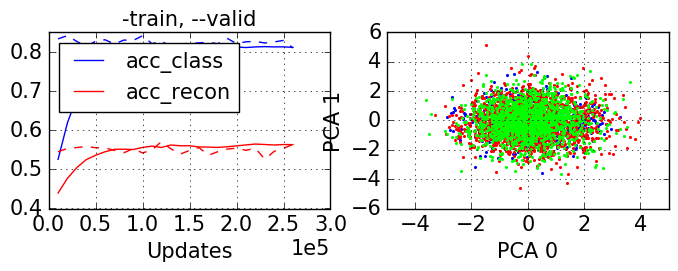

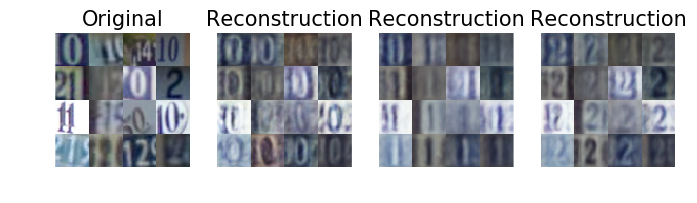

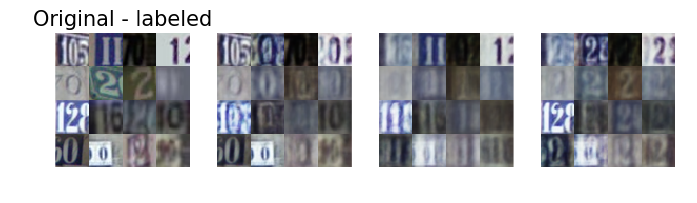

In [40]:
# TRAINING
from IPython.display import Image, display, clear_output
import sklearn.decomposition
pca = sklearn.decomposition.PCA(n_components=2)

output_dict={'samples_processed':[]
             ,'LL_train':[],
             'LL_train_u':[],
             'LL_train_l':[],
            'LL_valid':[],
            'certainty_class_u':[],
            'certainty_recon_u':[],
            'certainty_class_l':[],
            'recon_class_same_u':[],
            'mean_var_u':[],
            'mean_var_l':[],
            'KL_train_u':[],
            'KL_train_l':[],
            'acc_trai_rec':[],
            'acc_trai_class':[],
            'trai_class_rec_same':[],            
            'acc_vali_rec':[],
            'acc_vali_class':[],
            'vali_class_rec_same':[]}

LL_train, KL_train, logpx_train = [],[],[]
LL_valid, KL_valid, logpx_valid = [],[],[]
samples_processed = 0
plt_vals = []
plt_vals_t = []
samples_processed =0
valid_samples_processed = []
scalarInputs=11

out_accum=[0]*(scalarInputs)

idxs_ran = np.random.choice(range(x_trai.shape[0]), size=(x_trai.shape[0]), replace=False) 
train_pred_class=t_trai[idxs_ran]
idxs_ran = np.random.choice(range(x_trai.shape[0]), size=(x_trai.shape[0]), replace=False) 
train_pred_recon=t_trai[idxs_ran]


num_validation=0
try:
    while samples_processed < samples_to_process:
#        print("Number of samples processed: {}".format(samples_processed))
        idxs = np.random.choice(range(x_trai.shape[0]), size=(batch_size), replace=False) 
        x_batch = x_trai[idxs]
        t_batch = t_trai[idxs]

        if bernuli_sampling_train:
            x_batch_ber=np.random.binomial(1,x_batch,size=x_batch.shape).astype(theano.config.floatX)
            x_train_l_ber=np.random.binomial(1,x_train_l,size=x_train_l.shape).astype(theano.config.floatX)
            out = f_train(x_batch_ber, x_train_l_ber, t_train_l)
        else:
            out = f_train(x_batch, x_train_l, t_train_l)
#        uns_results.add_batch([out,t_batch],batch_size)
        train_pred_recon[idxs]=out[scalarInputs]
        train_pred_class[idxs]=out[scalarInputs+1]
        
        mean_factor=min(0.99,samples_processed/batch_size)
        samples_processed += batch_size

#        print(out_accum[i],mean_factor,(1-mean_factor),out[i])

        for i in range(scalarInputs):
            out_accum[i]=out_accum[i]*mean_factor+(1-mean_factor)*out[i].mean()
        

        
        if samples_processed >= (num_validation+1)*val_interval:
            valid_samples_processed += [samples_processed]
            #size_f(y_eval,LL_rec_eval)

            z_eval = f_z(x_vali)[0]
            
            out = f_eval_recon(x_vali)
            LL_valid += [out[0]]
            pred_y_class=out[1]
            pred_y_recon=out[2]
            

            
            #Confusion matrix validation
            pred_y_class_vec=np.argmax(pred_y_class,axis=1)
            pred_y_recon_vec=np.argmax(pred_y_recon,axis=1)
            t_vali_vec=np.argmax(t_vali,axis=1)
            pred_y_class_vec_correct=np.equal(pred_y_class_vec,t_vali_vec).astype('int')
            pred_y_recon_vec_correct=np.equal(pred_y_recon_vec,t_vali_vec).astype('int')
            confussion_class=np.zeros((num_classes,num_classes))
            confussion_recon=np.zeros((num_classes,num_classes))
            confussion_class_recon=np.zeros((2,2))
            for i in range(t_vali.shape[0]):
                confussion_class[pred_y_class_vec[i],t_vali_vec[i]]+=1
                confussion_recon[pred_y_recon_vec[i],t_vali_vec[i]]+=1
                confussion_class_recon[pred_y_recon_vec_correct[i],pred_y_class_vec_correct[i]]+=1
            confussion_class/=(t_vali.shape[0]*1.0)
            confussion_recon/=(t_vali.shape[0]*1.0)
            confussion_class_recon/=(t_vali.shape[0]*1.0)
            
            ##Accuracies use confusion matrix istead
            acc_vali_rec=np.sum(np.equal(np.argmax(pred_y_recon,axis=1),np.argmax(t_vali,axis=1)))/(t_vali.shape[0]*1.0)
            acc_vali_class=np.sum(np.equal(np.argmax(pred_y_class,axis=1),np.argmax(t_vali,axis=1)))/(t_vali.shape[0]*1.0)
            vali_class_rec_same=np.sum(np.equal(np.argmax(pred_y_recon,axis=1),np.argmax(pred_y_class,axis=1)))/(t_vali.shape[0]*1.0)
            
            acc_trai_rec=np.sum(np.equal(np.argmax(train_pred_recon,axis=1),np.argmax(t_trai,axis=1)))/(t_trai.shape[0]*1.0)
            acc_trai_class=np.sum(np.equal(np.argmax(train_pred_class,axis=1),np.argmax(t_trai,axis=1)))/(t_trai.shape[0]*1.0)
            trai_class_rec_same=np.sum(np.equal(np.argmax(train_pred_class,axis=1),np.argmax(train_pred_recon,axis=1)))/(t_trai.shape[0]*1.0)
            
            ####Update Output dict
            output_dict['samples_processed']+=[samples_processed]
            output_dict['LL_train']+=[out_accum[0]]
            output_dict['LL_train_u']+=[out_accum[1]]
            output_dict['LL_train_l']+=[out_accum[2]]
            output_dict['LL_valid']+=[np.mean(out[0])]
            output_dict['certainty_class_u']+=[out_accum[3]]
            output_dict['certainty_recon_u']+=[out_accum[6]]
            output_dict['certainty_class_l']+=[out_accum[7]]
            output_dict['recon_class_same_u']+=[out_accum[5]]
            output_dict['mean_var_u']+=[out_accum[4]]
            output_dict['mean_var_l']+=[out_accum[8]]
            output_dict['KL_train_u']+=[out_accum[9]]
            output_dict['KL_train_l']+=[out_accum[10]]
            output_dict['acc_trai_rec']+=[acc_trai_rec]
            output_dict['acc_trai_class']+=[acc_trai_class]
            output_dict['trai_class_rec_same']+=[trai_class_rec_same]            
            output_dict['acc_vali_rec']+=[acc_vali_rec]
            output_dict['acc_vali_class']+=[acc_vali_class]
            output_dict['vali_class_rec_same']+=[vali_class_rec_same]

            clear_output(wait=True)
            ####Printing outputs
            for i in sorted(output_dict.keys()):
                print(i,output_dict[i][-1])
            
            ##Printing confusion matrixes
            print('confussion matrix classifyer validation data')
            print(confussion_class)
            print('confussion matrix reconstruction validation data')
            print(confussion_recon)
            print('Mutual confusion matrix class and recon being correct - validation data')
            print(confussion_class_recon)
            
            
            ###############
            
            ### Plot learning curves 
            plt.subplot(2,2,1)
            plt.xlabel('Updates')
            plt.plot(output_dict['samples_processed'], output_dict['acc_trai_class'], 
                     color="blue", label='acc_class')
            plt.plot(output_dict['samples_processed'], output_dict['acc_trai_rec'], 
                     color="red", label='acc_recon')

            plt.plot(output_dict['samples_processed'], output_dict['acc_vali_class'], 
                     color="blue", 
                     linestyle="--")
            plt.plot(output_dict['samples_processed'], output_dict['acc_vali_rec'], 
                     color="red", 
                     linestyle="--")

            plt.legend(loc=2)
            plt.title('-train, --valid')
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.grid('on')

            ### Plot PCA of latent space
            plt.subplot(2,2,2)
            plt.cla()
            plt.xlabel('PCA 0'), plt.ylabel('PCA 1')
            color = iter(plt.get_cmap('brg')(np.linspace(0, 1.0, num_classes)))
            for i in range(num_classes):
                clr = next(color)
                pca_trans = pca.fit_transform(z_eval)
                plt.scatter(pca_trans[tls.onehot2int(t_vali)==i, 0], 
                            pca_trans[tls.onehot2int(t_vali)==i, 1], 
                            c=clr, 
                            s=5., 
                            lw=0, 
                            marker='o', )
            plt.grid('on')
            plt.show()

            
            
            t_plots=4
            x_plot=x_vali[np.random.choice(range(x_vali.shape[0]), size=(t_plots*t_plots), replace=False)]
            x_plot_recon = f_reconstruction(x_plot)
            org_plot=tls.plot_svhn(x_plot, 
                                             t=t_plots, cmap=cmap, IMG_LEN=IMG_LEN, 
                                             IMG_DEPTH=IMG_DEPTH,choose_random=False)
            #print(type(org_plot),org_plot)
            _, ax = plt.subplots(1,num_classes+1)
            ax[0].imshow(org_plot[0], cmap=cmap, interpolation='None')
            ax[0].set_title('Original')
            ax[0].axis('off')

            
            for c in range(num_classes):
                rec_plot=tls.plot_svhn(x_plot_recon[0][np.array(range(t_plots*t_plots))+(t_plots*t_plots)*c,:],t=t_plots, cmap=cmap, IMG_LEN=IMG_LEN, 
                                             IMG_DEPTH=IMG_DEPTH,choose_random=False)
                ax[c+1].imshow(rec_plot[0], cmap=cmap, interpolation='None')
                ax[c+1].set_title('Reconstruction')
                ax[c+1].axis('off')

                #plt.tight_layout()
            plt.show()
            
            x_plot=x_train_l[np.random.choice(range(x_train_l.shape[0]), size=(t_plots*t_plots), replace=False)]
            x_plot_recon = f_reconstruction(x_plot)
            org_plot=tls.plot_svhn(x_plot, 
                                             t=t_plots, cmap=cmap, IMG_LEN=IMG_LEN, 
                                             IMG_DEPTH=IMG_DEPTH,choose_random=False)
            #print(type(org_plot),org_plot)
            _, ax = plt.subplots(1,num_classes+1)
            ax[0].imshow(org_plot[0], cmap=cmap, interpolation='None')
            ax[0].set_title('Original - labeled')
            ax[0].axis('off')
            
            for c in range(num_classes):
                rec_plot=tls.plot_svhn(x_plot_recon[0][np.array(range(t_plots*t_plots))+(t_plots*t_plots)*c,:],
                                       t=t_plots, cmap=cmap, IMG_LEN=IMG_LEN, 
                                       IMG_DEPTH=IMG_DEPTH, choose_random=False)
                ax[c+1].imshow(rec_plot[0], cmap=cmap, interpolation='None')
                #ax[c+1].set_title('Reconstruction- labeled')
                ax[c+1].axis('off')

#             plt.tight_layout()
            plt.show()
            num_validation+=1
            
except KeyboardInterrupt:
    pass


In [36]:
print(output_dict)

{'certainty_recon_u': [0.92253016719251768], 'recon_class_same_u': [0.58584375995262095], 'KL_train_l': [16.35895101615959], 'certainty_class_l': [0.98970590497084865], 'certainty_class_u': [0.95467061339773995], 'trai_class_rec_same': [0.44491759324974373], 'LL_train_u': [-1915.7020491364347], 'mean_var_l': [-2.4451997658898015], 'acc_vali_rec': [0.54985119047619047], 'KL_train_u': [15.405648439472051], 'samples_processed': [10000], 'LL_valid': [-1917.9583], 'LL_train_l': [-1865.3290465612311], 'vali_class_rec_same': [0.56051587301587302], 'mean_var_u': [-2.3945772243409764], 'acc_trai_class': [0.5237362983991799], 'LL_train': [-3781.0310926986895], 'acc_trai_rec': [0.43888494598217809], 'acc_vali_class': [0.84647817460317465]}


(-0.5, 127.5, 127.5, -0.5)

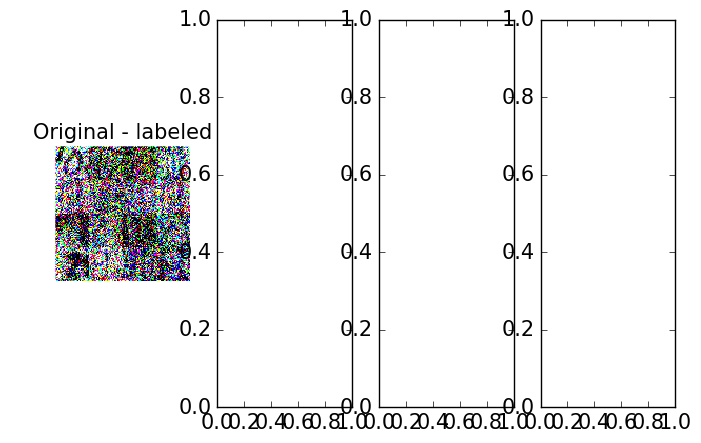

In [19]:
#             print("Samples processed: {} ".format(samples_processed)) 

#             print("LL_train :{}".format(out_accum[0]))
#             print("LL_train_u :{}".format(out_accum[1]))
#             print("LL_train_l :{}".format(out_accum[2]))
#             print("LL_valid :{}".format(LL_valid[-1]))
#             print('certainty_class_u:{}'.format(out_accum[3]))
#             print('certainty_recon_u:{}'.format(out_accum[6]))
#             print('certainty_class_l:{}'.format(out_accum[7]))
#             print('recon_class_same_u:{}'.format(out_accum[5]))
#             print('mean_var_u:{}'.format(out_accum[4]))
#             print('mean_var_l:{}'.format(out_accum[8]))
#             print('KL_train_u:{}'.format(out_accum[9]))
#             print('KL_train_l:{}'.format(out_accum[10]))
#             print('acc_vali_rec:{}'.format(acc_vali_rec))
#             print('acc_vali_class:{}'.format(acc_vali_class))
#             print('vali_class_rec_same:{}'.format(vali_class_rec_same))
#             print('acc_trai_rec:{}'.format(acc_trai_rec))
#             print('acc_trai_class:{}'.format(acc_trai_class))
#             print('trai_class_rec_same:{}'.format(trai_class_rec_same))
#             #print("Validation accuracies: {}".format([valid_accuracy_class[-1],valid_accuracy_recon[-1],valid_recon_class_same[-1]]))

In [29]:
1

1

In [21]:
print(valid_accuracy_class,valid_accuracy_recon,valid_recon_class_same)

NameError: name 'valid_accuracy_class' is not defined

('KL_train_l', 14.844172971513087)
('KL_train_u', 14.394116931630645)
('LL_train', -3801.1801065210698)
('LL_train_l', -1884.0890379758716)
('LL_train_u', -1917.0910503929815)
('LL_valid', -1919.6639)
('Samples_processed', 50000)
('acc_trai_class', 0.80403753647188703)
('acc_trai_rec', 0.48888100307546722)
('acc_vali_class', 0.8928571428571429)
('acc_vali_rec', 0.51736111111111116)
('certainty_class_l', 0.98661449491078734)
('certainty_class_u', 0.93211447498555877)
('certainty_recon_u', 0.91295692821806507)
('mean_var_l', -2.2254080874435802)
('mean_var_u', -2.2179869753587882)
('recon_class_same_u', 0.50875337390299169)
('trai_class_rec_same', 0.48202034539862787)
('vali_class_rec_same', 0.51215277777777779)


###  asdf